# Ames Housing Prediction ML Project

#### Kaggle Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Import Necessary Packages

In [8]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis (EDA) on the Data
- Create Total SF
- Plot scatterplots of main features: Total SF, TotRmsAbvGrd, YearBuilt, LotArea, OverallQual
- Remove Outliers
- Check for highly skewed features
- Check that there are features with no variation

In [9]:
train = pd.read_csv('train.csv')
train.set_index(train['Id'])
train.drop('Id', axis=1, inplace=True)
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

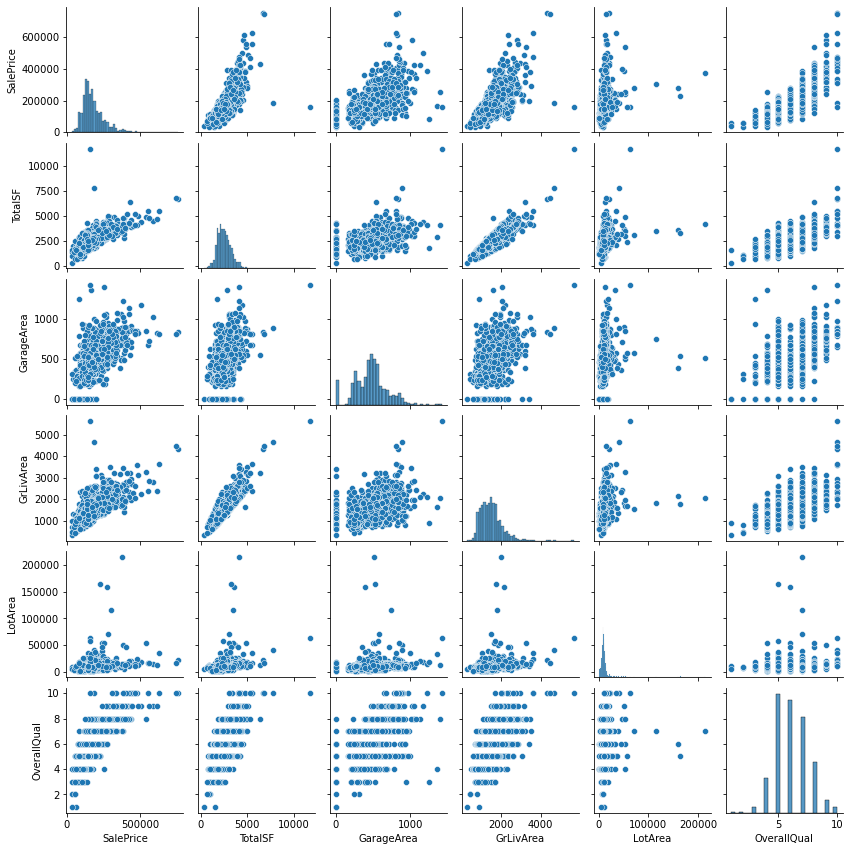

In [10]:
sns.pairplot(data=train[['SalePrice',
                         'TotalSF',
                         'GarageArea',
                         'GrLivArea',
                         'LotArea',
                         'OverallQual']], height=2)

Drop outliers and create the scatterplot again

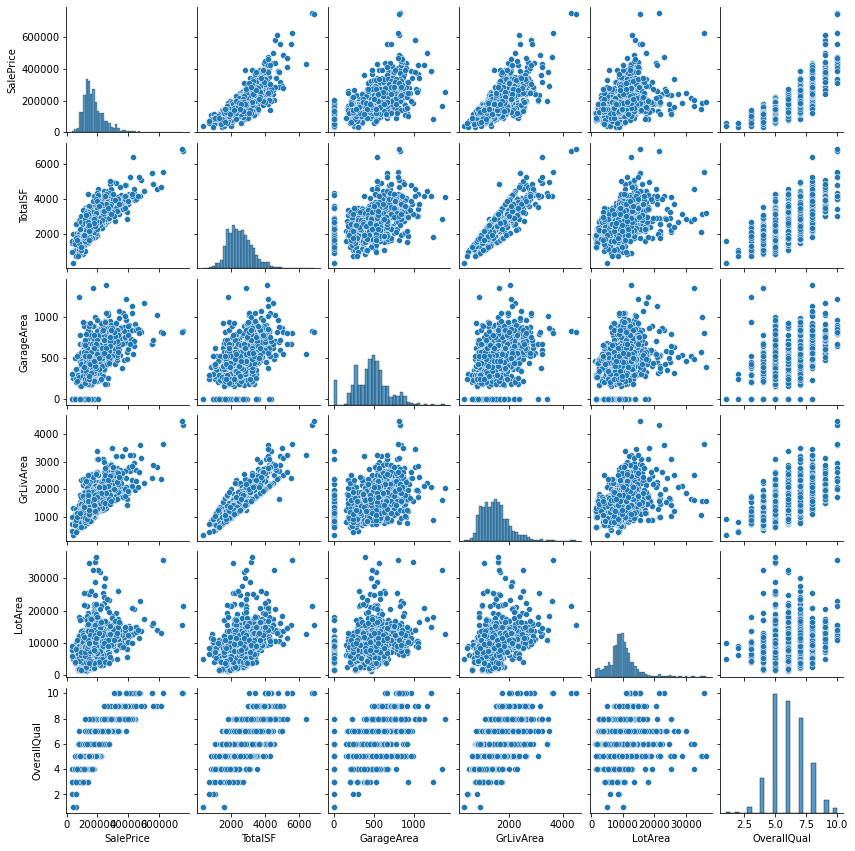

In [11]:
train.drop(train.index[train.TotalSF>7500],axis=0, inplace=True)
train.drop(train.index[train.LotArea>39000],axis=0, inplace=True)

sns.pairplot(data=train[['SalePrice',
                         'TotalSF',
                         'GarageArea',
                         'GrLivArea',
                         'LotArea',
                         'OverallQual']], height=2)

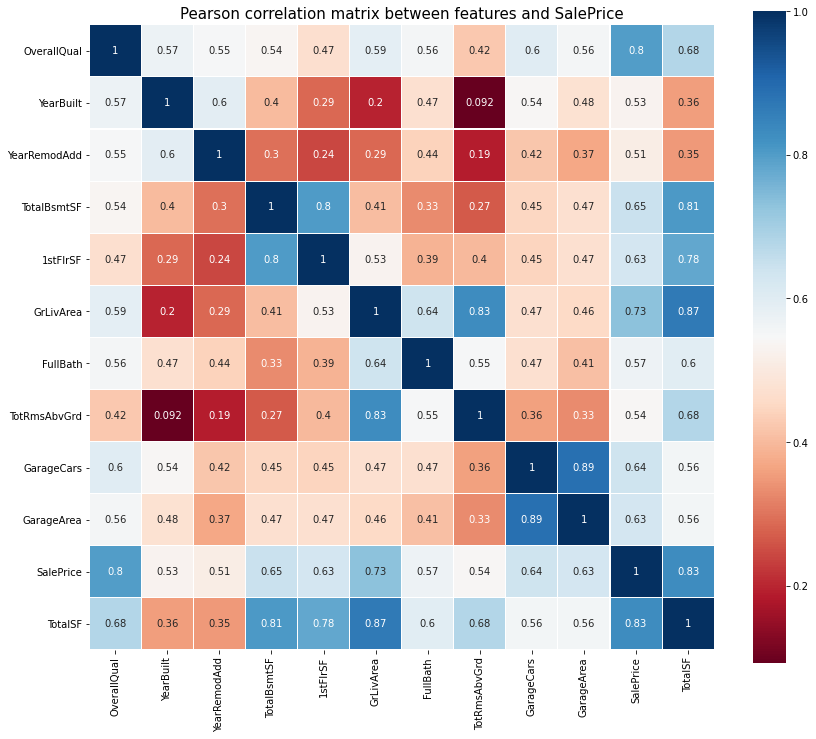

In [12]:
corr_train = train.corr()
highest_corr_features = corr_train.index[abs(corr_train['SalePrice']) > 0.5]

plt.figure(figsize=(14,12))
plt.title('Pearson correlation matrix between features and SalePrice', y=1, size=15)
sns.heatmap(train[highest_corr_features].corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True,
            cmap='RdBu',
            linecolor='white',
            annot=True)
plt.show()

In [13]:
# Check that there are no features with no variation
assert len(train.drop('SalePrice', axis=1).var()[lambda x: abs(x)<0.0001]) == 0

## Feature Engineering
Replace "NA" in categorical features to "None" whenever it is not a true null. Then impute the remaining missing values
- Numerical features: use sample median
- Ordinal features: use sample mode
- Non-ordinal categorical features: use sample mode

Encode categorical values
- Ordinal features: use ordinal encoder
- Non-ordinal categorical features: use target encoding

Create new features
- SqftAbvGrd: 1stFlrSF + 2ndFlrSF
- SqftPerRoom: TotalSF/TotRmsAbvGrd
- SqftAbvGrdPerRoom: SqftAbvGrd/TotRmsAbvGrd
- TotalBath = FullBath + 1/2 * HalfBath
- GarageQC: GarageQual + GarageCond
- ExterQC: ExterQual + ExterCond
- BsmtQC: BsmtQual + BsmtCond
- OveralQC = OverallQual + OverallCond

In [14]:
na_impute_list = [
    'Street', 'Alley', 'BsmtQual', 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
    'BsmtFinType2', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence', 'MiscFeature'
]
for att in na_impute_list:
    train[att].fillna('None', inplace=True)

Drop features with little variation or too much missing values where the largest category of the feature makes up 90% of the data.

In [15]:
drop_list = [
    'Street', 'Alley', 'Utilities', 
    'Condition2','RoofMatl', 'Heating', 
    'Electrical', 'PoolQC', 'MiscFeature'
]
train.drop(columns = drop_list, inplace=True)

In [16]:
nbd_list = [
    'SWISU', 'StoneBr', 'ClearCr', 
    'Blmngtn', 'MeadowV', 'BrDale', 
    'Veenker', 'NPkVill', 'Blueste'
]
for nbd in nbd_list:
    train['Neighborhood'].replace({nbd: 'Other'}, inplace=True)

In [17]:
def missing_impute(df):
    
    df_copy = df.copy()
    cols_missing_value = df_copy.columns[df_copy.isna().sum()>0].values
    
    '''
    Impute missing numerical features using median
    '''
    missing_num_att = df_copy[cols_missing_value].select_dtypes(exclude='object').columns
    for att in missing_num_att:
        df_copy[att].fillna(df_copy[att].median(), inplace=True)

    '''
    Impute missing ordinal/nonordinal features using mode
    '''  
    missing_cat_att = df_copy[cols_missing_value].select_dtypes(include='object').columns
    for att in missing_cat_att:
        nbd_dict = df_copy.groupby('Neighborhood')[att].apply(lambda x: x.mode().iloc[0])
        full_sample_dict = df_copy[att].mode()[0]
        df_copy[att].fillna(nbd_dict, inplace=True)
        df_copy[att].fillna(full_sample_dict, inplace=True)
    
    return df_copy

# Impute missing, check that total number of NAs is zero
train_impute = missing_impute(train)
total_missing = train_impute.isna().sum().sum()
print(f"Total number of NAs: {total_missing}")

Total number of NAs: 0


In [18]:
num_att = ['LotFrontage','LotArea','OverallQual',
           'OverallCond','YearBuilt','YearRemodAdd',
           'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
           'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
           'GrLivArea','BsmtFullBath','BsmtHalfBath',
           'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
           'TotRmsAbvGrd','Fireplaces','GarageYrBlt',
           'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
           'EnclosedPorch','3SsnPorch','ScreenPorch',
           'PoolArea','MiscVal','MoSold','YrSold', 'TotalSF']

ordinal_att = ['LotShape', 'LandSlope', 'ExterQual',
               'ExterCond','BsmtQual', 'BsmtCond',
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'HeatingQC','CentralAir', 'KitchenQual',
               'Functional','FireplaceQu', 'GarageFinish', 
               'GarageQual', 'GarageCond', 'PavedDrive', 
               'Fence']

nonordinal_att = ['MSSubClass', 'MSZoning', 'LandContour',
                  'LotConfig', 'Neighborhood', 'BldgType',
                  'HouseStyle', 'RoofStyle', 'MasVnrType',
                  'Foundation', 'GarageType', 'SaleType',
                  'SaleCondition', 'Condition1','Exterior1st',
                  'Exterior2nd']

Aggregate some non-ordinal categories to make sure that there are sufficient observations for target encoding (combine if there are less than 30 observations).

In [19]:
# Create feature list
features = num_att + ordinal_att + nonordinal_att

# Check all features are accounted for
assert len(features) - len(train_impute.drop('SalePrice', axis=1).columns) == 0

In [20]:
nonordinal_agg = dict()
nonordinal_encoder = dict()

for col in nonordinal_att:
    
    '''
    Combine categories that have less than 30 observations.
    Code them as 'Not Enough Observations'
    '''
    map_dict = train[col].value_counts()[lambda x : x < 30].to_dict()
        
    for key in map_dict.keys():
        map_dict[key] = 'Not Enough Observations'
    
    if map_dict:
        nonordinal_agg[col] = map_dict
        train_impute[col].replace(nonordinal_agg[col], inplace=True)   
    
    '''
    Create nonordinal dictionary for encoding later.
    '''
    impute_dict = train_impute.groupby(col).agg({'SalePrice':'mean'}).to_dict()
    nonordinal_encoder[col] = impute_dict['SalePrice']

In [21]:
def ordinal_encoder(df):
    '''
    ordinal encoder:
    return ordinal columns
    '''
    
    data = df.copy()
    
    # Quality/condition features
    QC = ['ExterQual', 'ExterCond',
          'BsmtQual', 'BsmtCond', 
          'HeatingQC', 
          'KitchenQual',
          'FireplaceQu', 
          'GarageQual', 'GarageCond']
    QC_dict = {'Po':1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex':5, 'None':0}
    data[QC] = data[QC].replace(QC_dict)
    
    # BsmtFinType
    BsmtFinType = ['BsmtFinType1', 'BsmtFinType2']
    BsmtFinType_dict = {'Unf':1, 'LwQ': 2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ': 6, 'None':0}
    data[BsmtFinType] = data[BsmtFinType].replace(BsmtFinType_dict)
    
    # BsmtExposure
    BsmtExposure_dict = {'No':1, 'Mn':2, 'Av':3, 'Gd': 4, 'None':0}
    data['BsmtExposure'] = data['BsmtExposure'].replace(BsmtExposure_dict)

    # CentralAir
    CentralAir_dict = {'N':1, 'Y':2}
    data['CentralAir'] = data['CentralAir'].replace(CentralAir_dict)
    
    # Fence
    Fence_dict = {'None':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}
    data['Fence'] = data['Fence'].replace(Fence_dict)
    
    # Functional
    Functional_dict = {'Sal':1, 'Sev':1, 'Maj1': 2, 'Maj2':2, 'Mod':3, 'Min1':4, "Min2": 4, "Typ": 5}
    data['Functional'] = data['Functional'].replace(Functional_dict)
    
    # GarageFinish
    GarageFinish_dict = {'Unf':1,'RFn': 2, 'Fin':3, 'None':0}
    data['GarageFinish'] = data['GarageFinish'].replace(GarageFinish_dict)
    
    # LandSlope
    LandSlope_dict = {'Sev':1, 'Mod':2, 'Gtl':3}
    data['LandSlope'] = data['LandSlope'].replace(LandSlope_dict)
    
    # LotShape
    LotShape_dict = {'IR3': 1, 'IR2':2, 'IR1':3, 'Reg':4}
    data['LotShape'] = data['LotShape'].replace(LotShape_dict)
    
    # PavedDrive
    PavedDrive_dict = {'N':1, 'P':2, 'Y': 3}
    data['PavedDrive'] = data['PavedDrive'].replace(PavedDrive_dict)
    
    return data

In [22]:
new_features = [
    'SqftAbvGrd', 'TotalSqftPerRoom', 'SqftAbvGrdPerRoom',
    'TotalBath', 'GarageQC', 'ExterQC', 'BsmtQC', 'OverallQC'
]
total_features = features + new_features
def tree_model_prep(df):
    
    data = df.copy()
    
    # Encode ordinal columns
    df_copy = ordinal_encoder(data)

    # Numerical columns
    numerical_cols = df_copy[num_att].to_numpy()
    
    # Ordinal columns
    ordinal_cols = df_copy[ordinal_att].to_numpy()
    
    # Nonordinal columns
    nonordinal_cols = df_copy[nonordinal_att].copy()
    
    for key in nonordinal_agg.keys():
        nonordinal_cols[key] = nonordinal_cols[key].replace(nonordinal_agg[key])
        
    for col in nonordinal_att:
        nonordinal_cols[col] = nonordinal_cols[col].replace(nonordinal_encoder[col])
    nonordinal_cols = nonordinal_cols.to_numpy()
        
    # Add new features
    df_copy['SqftAbvGrd'] = df_copy['1stFlrSF'] + df_copy['2ndFlrSF']
    df_copy['TotalSqftPerRoom'] = df_copy['TotalSF']/df_copy['TotRmsAbvGrd']
    df_copy['SqftAbvGrdPerRoom'] = df_copy['SqftAbvGrd']/df_copy['TotRmsAbvGrd']
    df_copy['TotalBath'] = df_copy['FullBath'] + (0.5 * df_copy['HalfBath']) 
    df_copy['GarageQC'] = df_copy['GarageQual'] + df_copy['GarageCond']
    df_copy['ExterQC'] = df_copy['ExterQual'] + df_copy['ExterCond']
    df_copy['BsmtQC'] = df_copy['BsmtQual'] + df_copy['BsmtCond']
    df_copy['OverallQC'] = df_copy['OverallQual'] + df_copy['OverallCond']
    new_features_col = df_copy[new_features].to_numpy()
    
    X = np.concatenate(
        [numerical_cols, ordinal_cols, nonordinal_cols, new_features_col], axis=1
    )
    
    return X

In [23]:
X_train = tree_model_prep(train_impute)
y_train = train['SalePrice'].copy()

## Model
The goal is to find a model that minimizes RMSE, where the target is log of "SalePrice." We will be experimenting with the following models:
- Random Forest Regression
- Gradient Boosting Regression
- Light Gradient Boosting Machine (LGBM) Regression
- Extreme Gradient Boosting (XGB) Regression
- Stacked Meta-Learner

***Step 1:***

Create helper functions that evaluate the RMSE score and perform K-fold cross validation on the train dataset to avoid overfitting.

***Step 2:***

Test models specified above and save the best model parameters.

***Step 3:***

Build a stacked regressor combining the base models and a linear regression meta learner.

### RMSE Helper Functions

In [5]:
# RMSE scorer
def get_rmse(y_actual, y_predict):
    log_y_actual = np.log(y_actual)
    log_y_predict = np.log(y_predict)
    mse = mean_squared_error(log_y_actual, log_y_predict)
    rmse = np.sqrt(mse)
    return rmse

# Initialize RMSE scorer
rmse_scorer = make_scorer(get_rmse, greater_is_better=False)

# Random state generator
rng = np.random.RandomState(17)

# K-Fold cross-validation RMSE
kfolds = KFold(n_splits=5, shuffle=True, random_state=rng)
def cv_rmse(model, X, y):
    cv_rmse = -cross_val_score(model, X, y, n_jobs=-1, scoring=rmse_scorer, cv=kfolds)
    return cv_rmse

### Random Forest Regressor

In [6]:
# Random Forest Regressor function
def RFR_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'min_samples_leaf' : int(params['min_samples_leaf']),
              'max_features' : int(params['max_features']),}
    
    model = RandomForestRegressor(random_state=rng, **params, n_jobs=-1)
           
    rmse_score = np.mean(cv_rmse(model, X_train, y_train))

    return rmse_score

In [21]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=1000, high=4000, q=250),
         'max_depth' : hp.quniform('max_depth', low=3, high=10, q=1),
         'min_samples_leaf' : hp.quniform('min_samples_leaf', low=5, high=20, q=1),
         'max_features' : hp.quniform('max_features', low=4, high=9, q=1),
         'max_samples' : hp.uniform('max_samples', low=0.5, high=0.8),}

trials = Trials()
RFR_best_params = fmin(fn=RFR_fn, 
                       space=space, 
                       algo=tpe.suggest, 
                       max_evals=25*5, 
                       trials=trials, 
                       rstate=rng)

param_list = ['n_estimators', 
              'max_depth',
              'min_samples_leaf',
              'max_features']

for param in param_list:
    RFR_best_params[param] = int(RFR_best_params[param])
    
pickle.dump(RFR_best_params, open("RFR.pkl", "wb"))
RFR_best_params

100%|██████████| 125/125 [17:00<00:00,  8.17s/trial, best loss: 0.1369968461731888]


{'max_depth': 10,
 'max_features': 9,
 'max_samples': 0.7818030701419609,
 'min_samples_leaf': 5,
 'n_estimators': 1250}

In [24]:
# Final score
RFR_best_params = pickle.load(open("RFR.pkl", "rb"))
RFR_fn(RFR_best_params)

0.13737450002363905

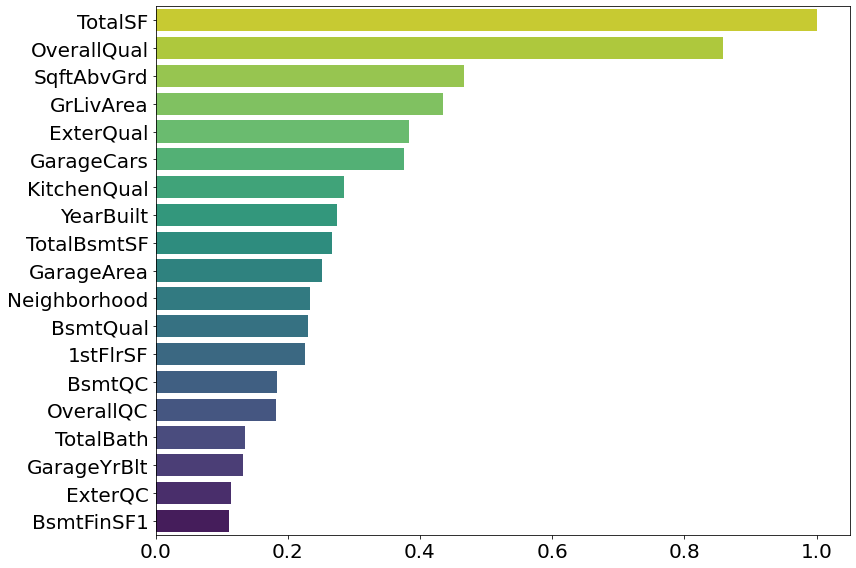

In [25]:
# Fit RFR Best and plot
RFR_best = RandomForestRegressor(random_state=rng, **RFR_best_params)
RFR_best.fit(X_train, y_train)

# Create plot data
plot_data = pd.DataFrame(zip(total_features, RFR_best.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance at least 0.1
f, ax = plt.subplots(figsize = (12,8))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='viridis_r')
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
f.tight_layout()

In [26]:
# Store best features
best_features = dict()
best_features['RFR'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values

### Gradient Boosting Regressor

In [27]:
# Gradient Boosting Regressor function
def GBR_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'learning_rate' : params['learning_rate'],
              'max_depth' : int(params['max_depth']),
              'min_samples_leaf' : int(params['min_samples_leaf']),
              'max_features' : int(params['max_features']),}
    
    model = GradientBoostingRegressor(random_state=rng, loss='huber', **params)
        
    score = np.mean(cv_rmse(model, X_train, y_train))
    
    return score

In [26]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=2500, high=5000, q=250),
         'learning_rate' : hp.uniform('learning_rate', low=0.04, high=0.06),
         'min_samples_leaf' : hp.quniform('min_samples_leaf', low=5, high=10, q=1),
         'max_depth' : hp.quniform('max_depth', low=1, high=10, q=1),
         'max_features' : hp.quniform('max_features', low=4, high=9, q=1),}

trials = Trials()
GBR_best_params = fmin(
    fn = GBR_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 25*5,
    trials = trials,
    rstate = rng
)

param_list = ['n_estimators', 
              'max_depth',
              'min_samples_leaf',
              'max_features']
for param in param_list:
    GBR_best_params[param] = int(GBR_best_params[param])
    
pickle.dump(GBR_best_params, open("GBR.pkl", "wb"))
GBR_best_params

100%|██████████| 125/125 [1:14:17<00:00, 35.66s/trial, best loss: 0.11341877202283945]


{'learning_rate': 0.04363469891604478,
 'max_depth': 4,
 'max_features': 4,
 'min_samples_leaf': 9,
 'n_estimators': 4250}

In [28]:
# Final score
GBR_best_params = pickle.load(open("GBR.pkl", "rb"))
GBR_fn(GBR_best_params)

0.11559583698554962

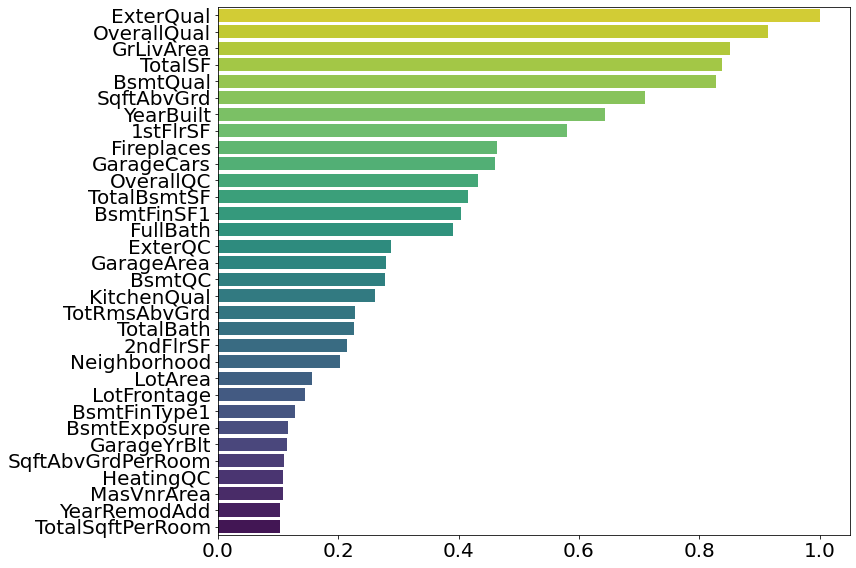

In [29]:
# Fit GBR Best and plot
GBR_best = GradientBoostingRegressor(random_state=rng, **GBR_best_params)
GBR_best.fit(X_train, y_train)

# Create plot data
plot_data = pd.DataFrame(zip(total_features, GBR_best.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance coefficient at least 0.1
f, ax = plt.subplots(figsize = (12,8))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='viridis_r')
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
f.tight_layout()

In [30]:
# Store best features
best_features['GBR'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values

### Light GBM

In [31]:
# Light Gradient Boosted Machine function
def LGBM_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'learning_rate' : params['learning_rate'],
              'max_depth' : int(params['max_depth']),
              'min_child_samples' : int(params['min_child_samples']),
              'num_leaves' : int(params['num_leaves']),
              'max_bin' : int(params['max_bin']),
              'subsample_freq' : int(params['subsample_freq']),
              'subsample' : params['subsample'],
              'reg_alpha' : params['reg_alpha'],
              'reg_lambda' : params['reg_lambda'],}
    
    model = LGBMRegressor(random_state=rng, **params)
        
    score = np.mean(cv_rmse(model, X_train, y_train))
    
    return score

In [31]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=2000, high=3000, q=250),
         'learning_rate' : hp.uniform('learning_rate', low=0.005, high=0.1),
         'max_depth' : hp.quniform('max_depth', low=3, high=10, q=1),
         'min_child_samples' : hp.quniform('min_child_samples', low=1, high=5, q=1),
         'num_leaves' : hp.quniform('num_leaves', low=10, high=30, q=2),
         'max_bin' : hp.quniform('max_bin', low=20, high=400, q=20),
         'subsample_freq' : hp.quniform('subsample_freq', low=5, high=10, q=1),
         'subsample' : hp.uniform('subsample', low=0.5, high=0.7),
         'reg_alpha' : hp.uniform('reg_alpha', low=0.2, high=0.4),
         'reg_lambda' : hp.uniform('reg_lambda', low=0.4, high=0.6),}

trials = Trials()
LGBM_best_params = fmin(
    fn = LGBM_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 25*5,
    trials = trials,
    rstate = rng
)

param_list = ['n_estimators', 
              'max_depth',
              'min_child_samples',
              'num_leaves',
              'max_bin',
              'subsample_freq']
for param in param_list:
    LGBM_best_params[param] = int(LGBM_best_params[param])
    
pickle.dump(LGBM_best_params, open("LGBM.pkl", "wb"))
LGBM_best_params

100%|██████████| 125/125 [15:26<00:00,  7.41s/trial, best loss: 0.11460408112984591]


{'learning_rate': 0.00659106380765096,
 'max_bin': 120,
 'max_depth': 9,
 'min_child_samples': 5,
 'n_estimators': 2250,
 'num_leaves': 12,
 'reg_alpha': 0.3224429113443517,
 'reg_lambda': 0.5696094334611045,
 'subsample': 0.6020713803364117,
 'subsample_freq': 10}

In [32]:
LGBM_best_params = pickle.load(open("LGBM.pkl", "rb"))
LGBM_fn(LGBM_best_params)

0.1180369414116059

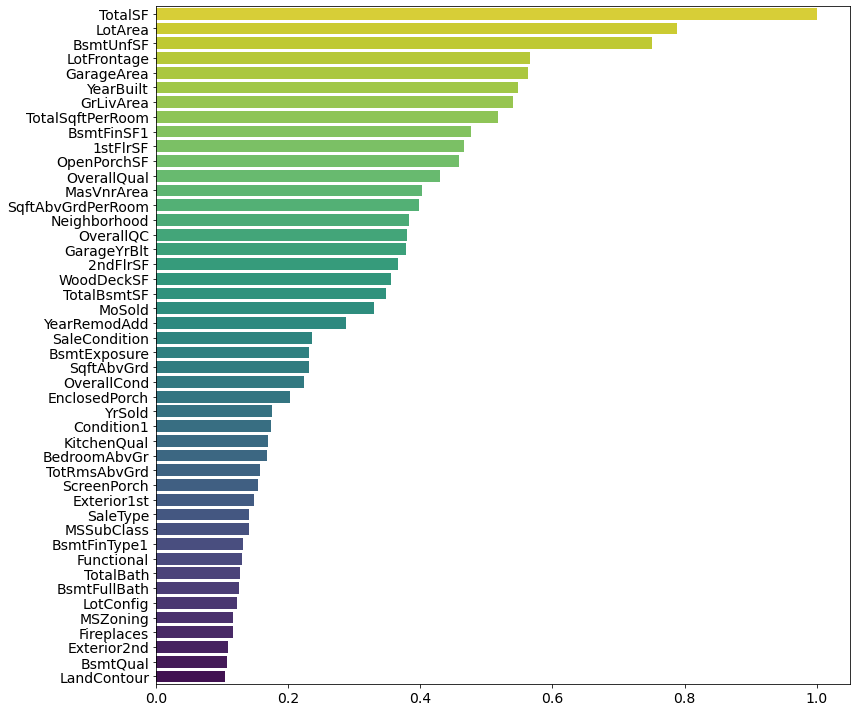

In [33]:
# Fit LGBM Best and plot
LGBM_best = LGBMRegressor(random_state=rng, **LGBM_best_params)
LGBM_best.fit(X_train, y_train)

# Create plot data
plot_data = pd.DataFrame(zip(total_features, LGBM_best.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance coefficient at least 0.1
f, ax = plt.subplots(figsize = (12,10))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='viridis_r')
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=14)
f.tight_layout()

In [34]:
# Store best features
best_features['LGBM'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values

### XGB Regressor

In [35]:
# Extreme Gradient Boosting function
def XGBR_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'learning_rate' : params['learning_rate'],
              'min_child_weight':int(params['min_child_weight']),
              'subsample':params['subsample'],
              'colsample_bytree':params['colsample_bytree'],
              'reg_alpha':params['reg_alpha'],
              'reg_lambda':params['reg_lambda'],}
    
    model = XGBRegressor(random_state=rng, **params)
        
    score = np.mean(cv_rmse(model, X_train, y_train))

    return score

In [36]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=3500, high=5500, q=250),
         'learning_rate': hp.uniform('learning_rate', low=0.03, high=0.07),
         'max_depth' : hp.quniform('max_depth', low=1, high=20, q=1),
         'min_child_weight':hp.quniform('min_child_weight', low=0, high=6, q=1),
         'subsample':hp.uniform('subsample', low=0.3, high=0.7),
         'colsample_bytree':hp.uniform('colsample_bytree', low=0.05, high=0.5),
         'reg_alpha':hp.uniform('reg_alpha', low=0, high=0.2),
         'reg_lambda':hp.uniform('reg_lambda', low=0.5, high=0.7),}

trials = Trials()
XGBR_best_params = fmin(
    fn = XGBR_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 25*5,
    trials = trials,
    rstate = rng
)

param_list = ['n_estimators', 
              'max_depth',
              'min_child_weight']
for param in param_list:
    XGBR_best_params[param] = int(XGBR_best_params[param])
    
pickle.dump(XGBR_best_params, open("XGBR.pkl", "wb"))
XGBR_best_params

100%|██████████| 125/125 [1:06:24<00:00, 31.88s/trial, best loss: 0.11452988693289512]


{'colsample_bytree': 0.14282514937350466,
 'learning_rate': 0.05166427191421964,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 5500,
 'reg_alpha': 0.11855603129312933,
 'reg_lambda': 0.6860888606247988,
 'subsample': 0.5136661695092485}

In [36]:
XGBR_best_params = pickle.load(open("XGBR.pkl", "rb"))
XGBR_fn(XGBR_best_params)

0.11714052660719643

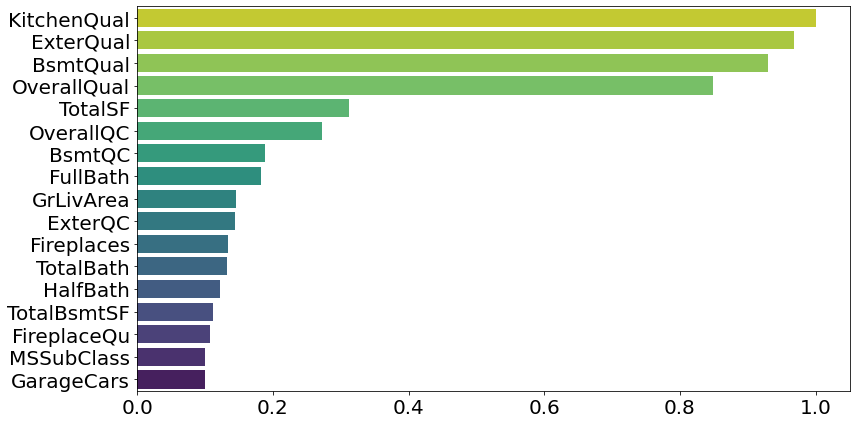

In [37]:
# Fit XGBR Best and plot
XGBR_best = XGBRegressor(random_state=rng, **XGBR_best_params)
XGBR_best.fit(X_train, y_train)

# Create plot data
plot_data = pd.DataFrame(zip(total_features, XGBR_best.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance coefficient at least 0.1
f, ax = plt.subplots(figsize = (12,6))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='viridis_r')
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=20)
f.tight_layout()

In [38]:
# Store best features
best_features['XGBR'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values

### Remove Less Important Features
- Removal of less important features can reduce variance and improve MSE.
- Since XGBoost had lowest RMSE so far, we will test XGBoost with a restricted feature set where we drop any features with less than 10% max feature importance in all of the models.
- The goal is to beat the CV MSE of 0.119

In [41]:
keep_features = list()
for best_feature in best_features.values():
    keep_features = keep_features + list(best_feature)
keep_features_count = Counter(keep_features)

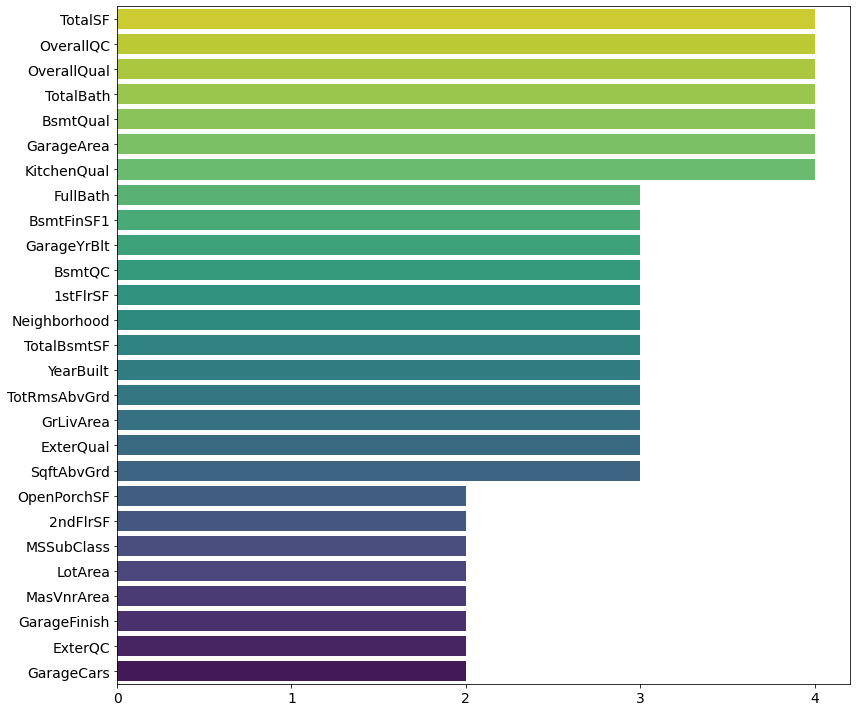

In [42]:
# Create plot data
plot_data = pd.DataFrame(zip(keep_features_count.keys(), keep_features_count.values()),
             columns = ['Feature', 'Count'])
plot_data = plot_data.sort_values(by = 'Count', ascending = False)

# Plot features that are considered "important" in multiple models
f, ax = plt.subplots(figsize = (12,10))
sns.barplot(data=plot_data.loc[plot_data.Count>1], 
            y='Feature', 
            x='Count',
            palette='viridis_r')
ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=14)
f.tight_layout()

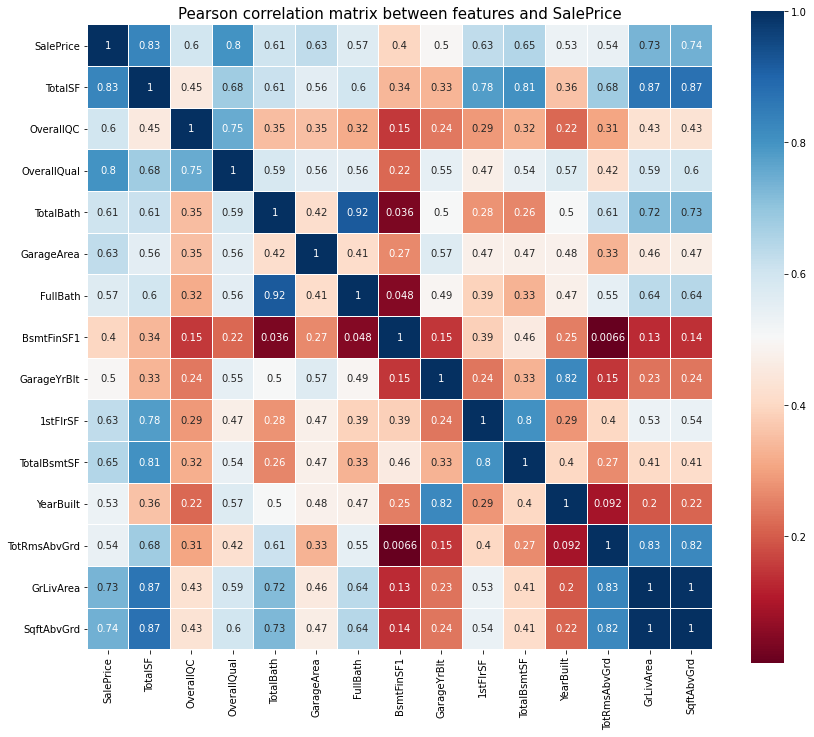

In [43]:
# Re-plot correlation plot using important features
most_important_features = ['SalePrice']
most_important_features = most_important_features + list(plot_data.loc[plot_data.Count>2]['Feature'])

train2 = train.copy()
train2['SqftAbvGrd'] = train2['1stFlrSF'] + train2['2ndFlrSF']
train2['TotalSqftPerRoom'] = train2['TotalSF']/train2['TotRmsAbvGrd']
train2['SqftAbvGrdPerRoom'] = train2['SqftAbvGrd']/train2['TotRmsAbvGrd']
train2['TotalBath'] = train2['FullBath'] + (0.5 * train2['HalfBath']) 
train2['GarageQC'] = train2['GarageQual'] + train2['GarageCond']
train2['ExterQC'] = train2['ExterQual'] + train2['ExterCond']
train2['BsmtQC'] = train2['BsmtQual'] + train2['BsmtCond']
train2['OverallQC'] = train2['OverallQual'] + train2['OverallCond']

plt.figure(figsize=(14,12))
plt.title('Pearson correlation matrix between features and SalePrice', y=1, size=15)
sns.heatmap(train2[most_important_features].corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True,
            cmap='RdBu',
            linecolor='white',
            annot=True)
plt.show()

In [44]:
# Restricted Feature Data Set
keep_features_set = list(set(keep_features))
X_train_res = pd.DataFrame(X_train, columns = total_features)
X_train_res = X_train_res[keep_features_set]

# Extreme Gradient Boosting function
def XGBR_res_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'learning_rate' : params['learning_rate'],
              'min_child_weight':int(params['min_child_weight']),
              'subsample':params['subsample'],
              'colsample_bytree':params['colsample_bytree'],
              'reg_alpha':params['reg_alpha'],
              'reg_lambda':params['reg_lambda'],}
    
    model = XGBRegressor(random_state=rng, **params)
        
    score = np.mean(cv_rmse(model, X_train_res, y_train))

    return score

In [45]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=3500, high=5000, q=250),
         'learning_rate': hp.uniform('learning_rate', low=0.03, high=0.07),
         'max_depth' : hp.quniform('max_depth', low=3, high=10, q=1),
         'min_child_weight':hp.quniform('min_child_weight', low=0, high=6, q=1),
         'subsample':hp.uniform('subsample', low=0.3, high=0.7),
         'colsample_bytree':hp.uniform('colsample_bytree', low=0.05, high=0.5),
         'reg_alpha':hp.uniform('reg_alpha', low=0, high=0.2),
         'reg_lambda':hp.uniform('reg_lambda', low=0.5, high=0.7),}

trials = Trials()
XGBR_res_best_params = fmin(
    fn = XGBR_res_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 25*5,
    trials = trials,
    rstate = rng
)

param_list = ['n_estimators', 
              'max_depth',
              'min_child_weight']
for param in param_list:
    XGBR_res_best_params[param] = int(XGBR_res_best_params[param])
    
pickle.dump(XGBR_res_best_params, open("XGBR_res.pkl", "wb"))
XGBR_res_best_params

100%|██████████| 125/125 [43:04<00:00, 20.68s/trial, best loss: 0.11318516198990292]


{'colsample_bytree': 0.26840463749168497,
 'learning_rate': 0.03473425084693394,
 'max_depth': 5,
 'min_child_weight': 2,
 'n_estimators': 4500,
 'reg_alpha': 0.0547030449199134,
 'reg_lambda': 0.5507673066647124,
 'subsample': 0.463452834158603}

CV MSE is a little better than 0.119, but not too significantly.

In [46]:
XGBR_res_best_params = pickle.load(open("XGBR_res.pkl", "rb"))
XGBR_res_fn(XGBR_res_best_params)

0.11451198827840595

### Meta-Learn 1: Stacked Regressor

In [41]:
# Stacking Regressor function
def Stacking_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'learning_rate' : params['learning_rate'],
              'min_child_weight':int(params['min_child_weight']),
              'subsample':params['subsample'],
              'colsample_bytree':params['colsample_bytree'],
              'reg_alpha':params['reg_alpha'],
              'reg_lambda':params['reg_lambda'],}
    
    estimators = [
        ('RFR', RFR_best),
        ('GBR', GBR_best),
        ('LGBM', LGBM_best),
        ('XGBR', XGBR_best),
    ]

    model = StackingRegressor(
        estimators = estimators,
        final_estimator = XGBRegressor(random_state = rng, **params),
        cv = kfolds,
        passthrough = True,
    )
        
    score = np.mean(cv_rmse(model, X_train, y_train))
    
    return score

In [48]:
# Hyperparameter tuning
space = {'n_estimators' : hp.quniform('n_estimators', low=2000, high=6000, q=250),
         'learning_rate': hp.uniform('learning_rate', low=0.01, high=0.05),
         'max_depth' : hp.quniform('max_depth', low=3, high=10, q=1),
         'min_child_weight' : hp.quniform('min_child_weight', low=0, high=6, q=1),
         'subsample' : hp.uniform('subsample', low=0.4, high=0.6),
         'colsample_bytree' : hp.uniform('colsample_bytree', low=0.2, high=0.5),
         'reg_alpha' : hp.uniform('reg_alpha', low=0, high=0.2),
         'reg_lambda' : hp.uniform('reg_lambda', low=0.5, high=0.8),}

trials = Trials()
Stacking_best_params = fmin(
    fn = Stacking_fn,
    space = space,
    algo = tpe.suggest,
    max_evals = 25*5,
    trials = trials,
    rstate = rng
)

param_list = ['n_estimators', 
              'max_depth',
              'min_child_weight']
for param in param_list:
    Stacking_best_params[param] = int(Stacking_best_params[param])
    
pickle.dump(Stacking_best_params, open("Stacking.pkl", "wb"))
Stacking_best_params

100%|██████████| 125/125 [7:58:10<00:00, 229.53s/trial, best loss: 0.11117436839135739]  


{'colsample_bytree': 0.4094418302150982,
 'learning_rate': 0.020555091001976687,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 2750,
 'reg_alpha': 0.057105702136245065,
 'reg_lambda': 0.5223311860773864,
 'subsample': 0.599169552183134}

In [42]:
Stacking_best_params = pickle.load(open("Stacking.pkl", "rb"))
Stacking_fn(Stacking_best_params)

0.11884556961965251

In [43]:
estimators = [
    ('RFR', RFR_best),
    ('GBR', GBR_best),
    ('LGBM', LGBM_best),
    ('XGBR', XGBR_best),
]
Stacking_best = StackingRegressor(
    estimators = estimators,
    final_estimator = XGBRegressor(random_state = rng, **Stacking_best_params),
    cv = kfolds,
    passthrough = True,
)

### Meta Learner 2: Voting Regressor (Weighted Average)

In [39]:
estimators = [('RFR_best', RFR_best), 
              ('GBR_best', GBR_best),
              ('LGBM_best', LGBM_best),
              ('XGBR_best', XGBR_best)]

# Calculate weights
weights = []
for estimator in estimators:
    score = estimator[1].score(X_train, y_train)
    weights.append(score)
    
weights = weights/np.sum(weights)
assert round(np.sum(weights),4)==1
    
# Voting 
VotingRegressor_best = VotingRegressor(estimators, weights=weights, n_jobs=-1)

In [40]:
# CV RMSE
np.mean(cv_rmse(VotingRegressor_best, X_train, y_train))

0.11505252602432987

### Create Table Summarizing Results

In [44]:
# Dollar difference helper function
def get_dollar_difference(model, X, y):
    model.fit(X,y)
    y_predict = model.predict(X)
    return mean_absolute_error(y, y_predict)

models = {'RFR_best' : RFR_best, 
          'GBR_best' : GBR_best,
          'XGBR_best' : XGBR_best,
          'LGBM_best': LGBM_best,
          'Stacking_best' : Stacking_best,
          'VotingRegressor_best' : VotingRegressor_best}

results = dict()
for name, model in models.items():
    
    dollar_diff = get_dollar_difference(model, X_train, y_train)
    rmse_mean = np.mean(cv_rmse(model, X_train, y_train))
    rmse_std = np.std(cv_rmse(model, X_train, y_train))

    values = {'dollar_diff': dollar_diff, 'rmse_mean': rmse_mean, 'rmse_std': rmse_std}
    results[name] = values

results_table = pd.DataFrame(results.values(), index=results.keys())
results_table.columns = columns = ['Dollar Difference', 'RMSE Mean', 'RMSE Std']
results_table.sort_values(by='RMSE Mean')

,Dollar Difference,RMSE Mean,RMSE Std
Stacking_best,4400.034718,0.114698,0.007529
VotingRegressor_best,4513.601304,0.115793,0.007678
XGBR_best,112.737589,0.117156,0.010075
LGBM_best,6678.924202,0.118967,0.014156
GBR_best,1073.345524,0.119697,0.006513
RFR_best,12124.190105,0.138701,0.004538


### Submit to Kaggle

In [45]:
test = pd.read_csv('test.csv')
test = test.set_index(test['Id'])
test.drop('Id', axis=1, inplace=True)
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [46]:
# Fill NA
for att in na_impute_list:
    test[att].fillna('None', inplace=True)
    
# Drop features
test.drop(columns = drop_list, inplace=True)

# Aggregate neighborhoods
for nbd in nbd_list:
    test['Neighborhood'].replace({nbd: 'Other'}, inplace=True)

# Impute
test_impute = missing_impute(test)
X_test = tree_model_prep(test_impute)

In [47]:
models = {'RFR_best' : RFR_best, 
          'GBR_best' : GBR_best,
          'XGBR_best' : XGBR_best,
          'LGBM_best': LGBM_best,
          'Stacking_best' : Stacking_best,
          'VotingRegressor_best' : VotingRegressor_best}

Id = test_impute.index.to_numpy()
for key in models.keys():
    model = models[key]
    model.fit(X_train, y_train)
    y_test = model.predict(X_test)
    y_test = pd.DataFrame(y_test, columns=['SalePrice'], index=Id)
    y_test.index.name = 'Id'
    filepath = str(key) + '_sub.csv'
    output = y_test.to_csv(filepath)